## Stanley tracker

Stanley controller was used in the DARPA-challenge winning autonomous vehicle, back in the day. 
It is a non-linear controller, which explicitly takes into account **ref_theta** unlike pure pursuit. Because it was used for a car, a bicycle model is to be used for vehicular motion

Trackers are trying to minimize 2 types of errors

1. Positional error or cross-track error $x_e$

2. Heading error $\theta_e$

Tracker controls the steering as a function of these 2 errors

$\delta = \theta_e + \tan^{-1}\frac{kx_e}{v}$

The second term can be thought of as how quickly do we want the vehicle to compensate for the positional error relative to vehicle velocity


Snider has a nice/ concise summary of how it works in Sec 2.3 of his Phd thesis
https://www.ri.cmu.edu/pub_files/2009/2/Automatic_Steering_Methods_for_Autonomous_Automobile_Path_Tracking.pdf

There is a reference implementation here
https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/stanley_controller/stanley_controller.py

+ Take the smoothened trajectory of straight/ right turn/ straight from week 2. 
+ Induce a small error in initial pose. 
+ Simulate vehicular motion using the Stanley tracker

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
# %matplotlib inline

In [2]:
def bicycle_model(curr_pose, v, delta, dt=1.0, l = 0.9):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0)
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.111111111111111)
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += v*np.tan(delta)*dt/l
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

In [3]:
vmax = 0.75
goal_threshold = 0.05

In [4]:
class StanleyTracker(object):
    def __init__(self, x, y, v, l=0.9, k=5e-2):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        """
        self.length = len(x)
        self.ref_idx = 0 #index on the path that tracker is to track
        self.x, self.y = x, y
        self.k, self.l = k, l
        self.v, self.delta = v, 0 # Considering v_x(t) as constant

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update delta based on current pose
        Returns True if trajectory is over.
        """
        
        xc = xc + np.cos(theta)*self.l/2 # Mid point of the robot
        yc = yc + np.sin(theta)*self.l/2
        
        if (self.ref_idx >= self.length):
            return True
        ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
        goal_x, goal_y = self.x[-1], self.y[-1]
        if np.linalg.norm([ref_x-goal_x, ref_y-goal_y]) < goal_threshold:
                return True
        
        # Find cross_track_error
        self.ref_idx = self.ref_idx + np.argmin(np.hypot(x[self.ref_idx:]-xc,y[self.ref_idx:]-yc))
        ref_x,ref_y = self.x[self.ref_idx],self.y[self.ref_idx]
        
        # Thanks: https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/stanley_controller/stanley_controller.py
        front_axle_vec = [np.cos(theta+np.pi/2),
                          np.sin(theta+np.pi/2)]
        cross_track_error = np.dot([x[self.ref_idx]-xc, y[self.ref_idx]-yc], front_axle_vec)

        # Find theta_p
        if self.ref_idx < self.length-1:
            theta_p = np.arctan2((self.y[self.ref_idx+1]-ref_y),(self.x[self.ref_idx+1]-ref_x))
        else:
            theta_p = np.arctan2((ref_y-self.y[self.ref_idx-1]),(ref_x-self.x[self.ref_idx-1]))
        theta_error = theta_p - theta
        
        theta_error = np.arctan2(np.sin(theta_error),np.cos(theta_error)) # normalizing theta between [-pi,pi]
        
        self.delta = theta_error + np.arctan2(self.k*cross_track_error,self.v)

        return False

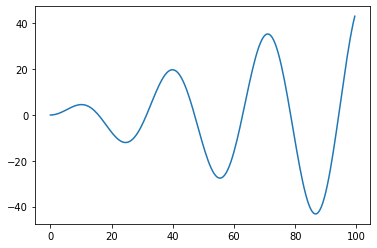

In [5]:
x = np.arange(0, 100, 0.5)
y = [np.sin(idx / 5.0) * idx / 2.0 for idx in x]

#write code here
plt.figure()
plt.plot(x,y)
plt.show()

In [6]:
#write code to instantiate the tracker class
tracker = StanleyTracker(x,y,vmax) 
pose = -1, 2, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting
traj =[]
# for i in range(4000):
while True:
    #write the usual code to obtain successive poses
    pose = bicycle_model(pose, tracker.v, tracker.delta, dt=0.1)
    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.delta, tracker.ref_idx])

ARRIVED!!


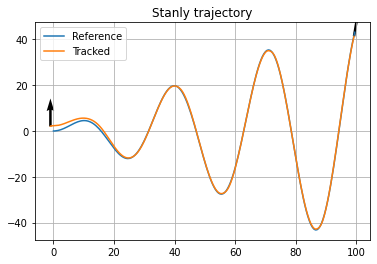

In [7]:
xs,ys,ts,ws,ids = zip(*traj)
plt.figure()
plt.plot(x,y,label='Reference')
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.plot(xs,ys,label='Tracked')
x0,y0,t0 = pose
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.title('Stanly trajectory')
plt.legend()
plt.grid()

4725


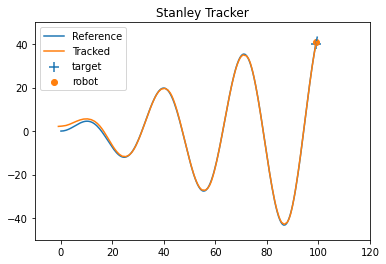

In [8]:
pose = -1, 2, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting

print(len(traj))

fig, ax = plt.subplots()
ax.plot(x,y,label='Reference')
x_target = x[traj[0][4]]
y_target = y[traj[0][4]]
scatter_target = ax.scatter(x_target,y_target,marker="+",s=100, label="target")
scatter_current = ax.scatter(x_target,y_target,label="robot")

ax.set_xlim(-10,120)
ax.set_ylim(-50,50)
plt.title("Stanley Tracker")
    
x_data = []
y_data = []
line = ax.plot(x_data,y_data, label="Tracked")[0]
def anim(i):
    i = int(i)

    x_data.append(traj[i][0])
    y_data.append(traj[i][1])
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    x_target = x[traj[i][4]]
    y_target = y[traj[i][4]]
    scatter_target.set_offsets(np.array([[x_target, y_target]]))
    scatter_current.set_offsets(np.array([[traj[i][0], traj[i][1]]]))

animation = FuncAnimation(fig,func=anim,frames=np.arange(1,len(traj),20),interval=10)


rc('animation', html='jshtml')
rc('animation', embed_limit=4096)

ax.legend()

animation